In [8]:
from principal_RBM_alpha import * 
from principal_DBN_alpha import * 
from principal_DNN_MNIST import * 
import torch
import numpy as np
from time import time
from tqdm import tqdm
import torchvision
import gc
import pandas as pd

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

### Visualisation du préentrainement d'une RBM sur BinaryAlphaDigits

Nous allons visualiser l'entrainement de notre RBM sur la base de données BinaryAlphadigits. Dans un premier temps, on considère le préentrainement sur le nombre $8$

In [3]:
index = 10
X  = lire_alpha_digit(index, device)

In [4]:
print('Les données contiennent:')
print(f'{X.size(0)} examples')
print(f'{X.size(1)} pixels')


Les données contiennent:
39 examples
320 pixels


In [5]:

p = X.size(1) #Nombre de pixels
qs = [10,100,500] #Test de différents nombres de neuronnes dans la couche cachée
batch_size = 10 #Le nombre de données par batch
lr = 0.1 #Le pas dans la gradient ascent
epochs = 1000 #Le nombre d'itérations (nombre de fois que le modèle voit toutes les données)
n_images = 2 #Nombre d'images à générer une fois la RBM entrainée
gibbs_iter = 1000 #Nombre d'itération dans le gibbs sampler pour générer une image

historique = []
images_RBM = []
times_RBM = []

for q in qs : 
    t0 = time()
    print(f'RBM avec {q} neuronnes')
    RBM = init_RBM(p, q, device)
    trained_RBM, history = train_RBM(X, RBM, epochs, lr, batch_size)
    historique.append(history)
    gen_images = generer_image_RBM(trained_RBM, gibbs_iter, n_images, plot = False)
    print('')
    times_RBM.append(time()-t0)
    images_RBM.append(gen_images)

RBM avec 10 neuronnes


EPOCH 999 - Reconstruction Error: 23.6630: 100%|█| 1000/1000 [00:04<00:00, 215.6



RBM avec 100 neuronnes


EPOCH 999 - Reconstruction Error: 0.0289: 100%|█| 1000/1000 [00:04<00:00, 219.36



RBM avec 500 neuronnes


EPOCH 999 - Reconstruction Error: 0.0009: 100%|█| 1000/1000 [00:04<00:00, 209.12


In [6]:
print(f'Training time (GPU) 10 neuronnes: {times_RBM[0]:0.3f} seconds')
print(f'Training time (GPU) 100 neuronnes: {times_RBM[1]:0.3f} seconds')
print(f'Training time (GPU) 500 neuronnes: {times_RBM[2]:0.3f} seconds')

Training time (GPU) 10 neuronnes: 4.865 seconds
Training time (GPU) 100 neuronnes: 4.806 seconds
Training time (GPU) 500 neuronnes: 5.078 seconds


Le temps d'entraînement n'augmente presque pas avec le nombre de neuronnes. Cela est probablement du à l'utilisation du GPU par Pytorch

Text(0, 0.5, 'Reconstruction Error')

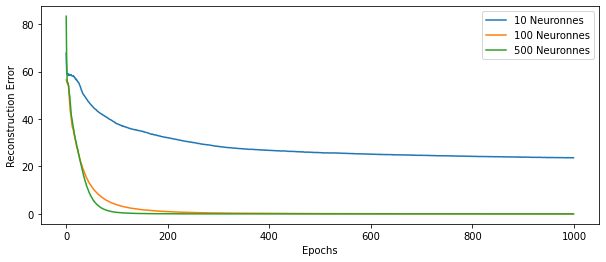

In [7]:
plt.figure(figsize = (10,4))
plt.plot(historique[0], label = '10 Neuronnes')
plt.plot(historique[1], label = '100 Neuronnes')
plt.plot(historique[2], label = '500 Neuronnes')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')


Nous voyons qu'une RBM avec 10 neuronnes ne convergent pas, tandis qu'une RBM avec 100 ou 500 neuronnes convergent vers une erreur de reconstruction très faible. Par ailleurs, l'utilisation de 500 neuronnes permet une convergence plus rapide.

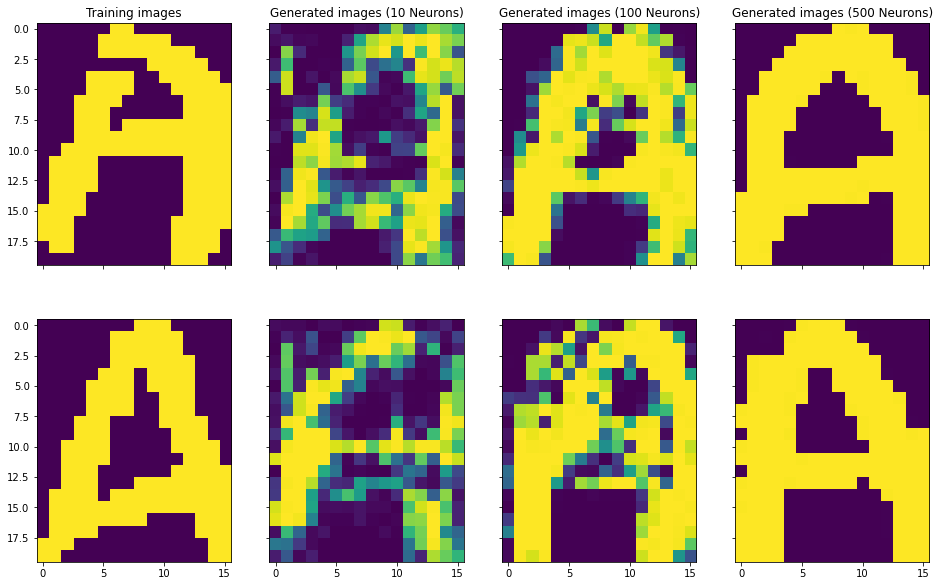

In [8]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, sharex = True, sharey = True, figsize = (16,10))

ax[0,0].imshow(X[0].view(20,16).cpu().numpy())
ax[1,0].imshow(X[10].view(20,16).cpu().numpy())
ax[0,0].set_title('Training images')

ax[0,1].imshow(images_RBM[0][0])
ax[1,1].imshow(images_RBM[0][1])
ax[0,1].set_title('Generated images (10 Neurons)')

ax[0,2].imshow(images_RBM[1][0])
ax[1,2].imshow(images_RBM[1][1])
ax[0,2].set_title('Generated images (100 Neurons)')

ax[0,3].imshow(images_RBM[2][0])
ax[1,3].imshow(images_RBM[2][1])
_=ax[0,3].set_title('Generated images (500 Neurons)')


Les RBM avec 100 et 500 neuronnes génèrent des images aussi proche que celles utilisées pourt l'entraînement.

### Visualisation du préentrainement d'un DBN sur BinaryAlphaDigits

In [10]:

p = X.size(1) #Nombre de pixels
qs = [100,500] #Test de différents nombres de neuronnes dans la couche cachée
n_layers = [1,3]
batch_size = 10 #Le nombre de données par batch
lr = 0.1 #Le pas dans la gradient ascent
epochs = 1000 #Le nombre d'itérations (nombre de fois que le modèle voit toutes les données)
n_images = 2 #Nombre d'images à générer une fois la RBM entrainée
gibbs_iter = 1000 #Nombre d'itération dans le gibbs sampler pour générer une image

images_DBN = []
times_DBN = []

for q in qs : 
    for n in n_layers : 
        t0 = time()
        print(f'DBN avec {n} couches cachées de {q} neuronnes')
        sizes = [(X.size(1), q)]
        for j in range(n) : 
            sizes.append((q, q)) 
        DNN = init_DNN(len(sizes), sizes, device)
        trained_DNN = pretrain_DNN(
             X, DNN, epochs, lr, batch_size, DBN = True
         )
        gen_images = generer_image_DBN(trained_DNN, gibbs_iter, n_images, plot = False)
        print('')
        times_DBN.append(time()-t0)
        images_DBN.append(gen_images)

DBN avec 1 couches de 100 neuronnes


EPOCH 999 - Reconstruction Error: 0.0262: 100%|█| 1000/1000 [00:04<00:00, 218.09
EPOCH 999 - Reconstruction Error: 0.0041: 100%|█| 1000/1000 [00:04<00:00, 219.80



DBN avec 3 couches de 100 neuronnes


EPOCH 999 - Reconstruction Error: 0.0269: 100%|█| 1000/1000 [00:04<00:00, 216.20
EPOCH 999 - Reconstruction Error: 0.0038: 100%|█| 1000/1000 [00:04<00:00, 232.97
EPOCH 999 - Reconstruction Error: 0.0030: 100%|█| 1000/1000 [00:04<00:00, 226.07
EPOCH 999 - Reconstruction Error: 0.0021: 100%|█| 1000/1000 [00:04<00:00, 226.40



DBN avec 1 couches de 500 neuronnes


EPOCH 999 - Reconstruction Error: 0.0009: 100%|█| 1000/1000 [00:04<00:00, 219.26
EPOCH 999 - Reconstruction Error: 0.0005: 100%|█| 1000/1000 [00:04<00:00, 211.03



DBN avec 3 couches de 500 neuronnes


EPOCH 999 - Reconstruction Error: 0.0011: 100%|█| 1000/1000 [00:04<00:00, 220.83
EPOCH 999 - Reconstruction Error: 0.0005: 100%|█| 1000/1000 [00:04<00:00, 216.46
EPOCH 999 - Reconstruction Error: 0.0002: 100%|█| 1000/1000 [00:04<00:00, 206.65
EPOCH 999 - Reconstruction Error: 0.0003: 100%|█| 1000/1000 [00:04<00:00, 201.39


In [11]:
print(f'Training time (GPU) 2 couches - 100 neuronnes: {times_DBN[0]:0.3f} seconds')
print(f'Training time (GPU) 4 couches - 100 neuronnes: {times_DBN[1]:0.3f} seconds')
print(f'Training time (GPU) 2 couches - 500 neuronnes: {times_DBN[2]:0.3f} seconds')
print(f'Training time (GPU) 4 couches - 500 neuronnes: {times_DBN[3]:0.3f} seconds')

Training time (GPU) 2 couches - 100 neuronnes: 9.875 seconds
Training time (GPU) 4 couches - 100 neuronnes: 18.984 seconds
Training time (GPU) 2 couches - 500 neuronnes: 10.024 seconds
Training time (GPU) 4 couches - 500 neuronnes: 20.418 seconds


Le temps d'entraînement semble augmenter linéairement avec le nombre de couches. Cependant, le nombre de neuronnes ne l'affecte pas beaucoup 

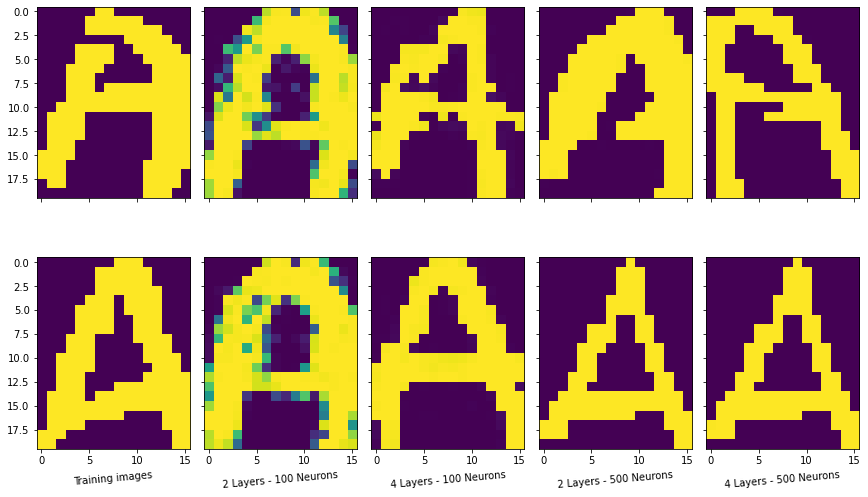

In [21]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True, figsize = (12,8))

ax[0,0].imshow(X[0].view(20,16).cpu().numpy())
ax[1,0].imshow(X[10].view(20,16).cpu().numpy())
ax[1,0].set_xlabel('Training images', rotation = 5)

ax[0,1].imshow(images_DBN[0][0])
ax[1,1].imshow(images_DBN[0][1])
ax[1,1].set_xlabel('2 Layers - 100 Neurons', rotation = 5)

ax[0,2].imshow(images_DBN[1][0])
ax[1,2].imshow(images_DBN[1][1])
ax[1,2].set_xlabel('4 Layers - 100 Neurons', rotation = 5)

ax[0,3].imshow(images_DBN[2][0])
ax[1,3].imshow(images_DBN[2][1])
ax[1,3].set_xlabel('2 Layers - 500 Neurons', rotation = 5)

ax[0,4].imshow(images_DBN[3][0])
ax[1,4].imshow(images_DBN[3][1])
_ = ax[1,4].set_xlabel('4 Layers - 500 Neurons', rotation = 5)
plt.tight_layout()


##### Génération d'Image pour le rapport

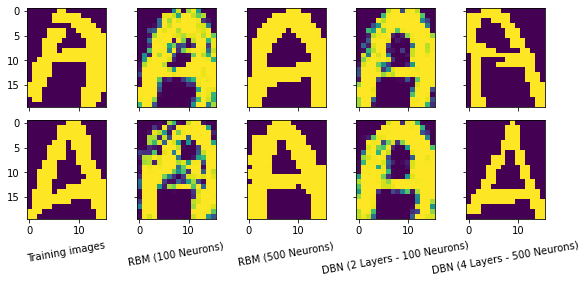

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True, figsize = (8,4))

ax[0,0].imshow(X[0].view(20,16).cpu().numpy())
ax[1,0].imshow(X[10].view(20,16).cpu().numpy())
ax[1,0].set_xlabel('Training images', rotation = 10)

ax[0,1].imshow(images_RBM[1][0])
ax[1,1].imshow(images_RBM[1][1])
ax[1,1].set_xlabel('RBM (100 Neurons)', rotation = 10)

ax[0,2].imshow(images_RBM[2][0])
ax[1,2].imshow(images_RBM[2][1])
_=ax[1,2].set_xlabel('RBM (500 Neurons)', rotation = 10)

ax[0,3].imshow(images_DBN[0][0])
ax[1,3].imshow(images_DBN[0][1])
ax[1,3].set_xlabel('DBN (2 Layers - 100 Neurons)', rotation = 10)

ax[0,4].imshow(images_DBN[3][0])
ax[1,4].imshow(images_DBN[3][1])
_ = ax[1,4].set_xlabel('DBN (4 Layers - 500 Neurons)', rotation = 10)
plt.tight_layout()

plt.savefig('figures/image_generation_rbm_dbn.jpg', dpi=600)

### Classfication avec un DNN

Pour la classification, on considère le dataset MNIST contenant des images en $28\times28$ pixels représentant des chiffres de $0$ à $9$. On possède $60000$ images pour l'entrainement et $10000$ images pour tester la généralisation de notre modèle.

On va utiliser un DNN - un DBN contenant une couche de classification supplémentaire. On divise le jeu en jeu d'entraînement (train), validation (pour déterminer un critère d'arrêt d'entrainement) et de test. On utilisera $5\%$ du jeu d'entrainement en tant que jeu de validation pour la dernière partie consistant à trouver le meilleure jeu d'hyperparamètres.

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = lire_mnist(device = device, val_size = 0)

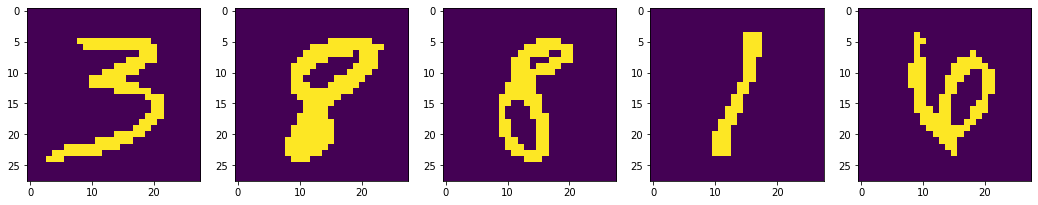

In [16]:
fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (18,12))

for j in range(5) : 
    ax[j].imshow(X_train[np.random.randint(X_train.size(0))].reshape(28,28).cpu().numpy())

On s'intéresse à deux types de **DNN*: 

- Un **DNN** préentrainé: on performe dans un premier temps un entrainement non supervisé de toutes les couches (hors couche de classification) du DNN de la même manière que l'on a entrainé le DBN. On entraine ensuite le **DNN** en utilisant l'alogrithme de rétropropagation.
- Un **DNN** initalisé aléatoirement, entrainé avec l'alogrithme de rétropropagation.

Dans les deux cas, les **DNN** seront initialisés avec les mêmes poids. Pour cela, on utilise le code suivant:

In [5]:
sizes = [(10,10), (10,10)]
DNN_1 = init_DNN(len(sizes), sizes, device, random_state = 42)
DNN_2 = init_DNN(len(sizes), sizes, device, random_state = 42)

##Checking that the parameters are equal across RBMs
assertions = []
for layer in range(len(sizes)) : 
    rbm_1 = DNN_1[layer]
    rbm_2 = DNN_2[layer]
    assertions.append(torch.all( torch.isclose(rbm_1.W, rbm_2.W, atol = 1e-9)).item() )
    assertions.append(torch.all( torch.isclose(rbm_1.b, rbm_2.b, atol = 1e-9)).item() )
    assertions.append(torch.all( torch.isclose(rbm_1.a, rbm_2.a, atol = 1e-9)).item() )
    
#3 params / RBMs
n_params = len(sizes) * 3 
print(f'Number of parameters equal between RBMs: {sum(assertions)}')
print(f'Number of parameters: {n_params}')

Number of parameters equal between RBMs: 6
Number of parameters: 6


### Expérience 1

On s'intéresse a la différence entre un **DNN** préentrainé et un **DNN** initialisé aléatoirement pour une nombre fixé de neuronnes en faisant varier le nombre de couches:

In [18]:
qs = [200, 500]
nlayers = [0, 1, 2, 3, 4]
epochs_retro = 200
epochs_pretrain = 100
lr = 0.1
batch_size = 512 

losses = []
accuracies_test = []
accuracies_train = []
for q in qs : 
    for n in nlayers : 
        print(f'DNN {n} layers with {q} neurons')
        sizes = [(X_train.size(1), q)]
        for j in range(n) : 
            sizes.append((q, q))
        sizes.append((q, 10))

        DNN_1 = init_DNN(len(sizes), sizes, device, random_state = 42)
        DNN_2 = init_DNN(len(sizes), sizes, device, random_state = 42)

        # RETRO SANS PRETRAIN #
        DNN_1, history_1 = retropropagation(X_train, y_train, DNN_1, epochs_retro, lr, batch_size)

        # RETRO AVEC PRETRAIN
        DNN_2 = pretrain_DNN(X_train, DNN_2, epochs_pretrain, lr, batch_size)
        DNN_2, history_2 = retropropagation(X_train, y_train, DNN_2, epochs_retro, lr, batch_size)
        
        accuracy_test_1 = test_DNN(X_test,y_test, DNN_1)
        accuracy_train_1 = test_DNN(X_train, y_train, DNN_1)

        accuracy_test_2 = test_DNN(X_test,y_test, DNN_2)
        accuracy_train_2 = test_DNN(X_train, y_train, DNN_2)

        losses.append((history_1, history_2))
        accuracies_train.append((accuracy_train_1, accuracy_train_2))
        accuracies_test.append((accuracy_test_1, accuracy_test_2))
        
        del DNN_1, DNN_2
        torch.cuda.empty_cache()
        gc.collect()

DNN 0 layers with 200 neurons


Epoch 200 | loss : 0.105 | accuracy  0.97: 100%|█| 200/200 [00:24<00:00,  8.10it
EPOCH 99 - Reconstruction Error: 8.0537: 100%|█| 100/100 [00:24<00:00,  4.08it/s
Epoch 200 | loss : 0.135 | accuracy  0.96: 100%|█| 200/200 [00:25<00:00,  7.70it


DNN 1 layers with 200 neurons


Epoch 200 | loss : 0.103 | accuracy  0.97: 100%|█| 200/200 [00:33<00:00,  5.93it
EPOCH 99 - Reconstruction Error: 8.0671: 100%|█| 100/100 [00:25<00:00,  3.88it/s
EPOCH 99 - Reconstruction Error: 2.3134: 100%|█| 100/100 [00:12<00:00,  8.32it/s
Epoch 200 | loss : 0.099 | accuracy  0.97: 100%|█| 200/200 [00:33<00:00,  5.92it


DNN 2 layers with 200 neurons


Epoch 200 | loss : 2.408 | accuracy  0.10: 100%|█| 200/200 [00:40<00:00,  4.94it
EPOCH 99 - Reconstruction Error: 8.0665: 100%|█| 100/100 [00:25<00:00,  3.86it/s
EPOCH 99 - Reconstruction Error: 2.3588: 100%|█| 100/100 [00:12<00:00,  7.86it/s
EPOCH 99 - Reconstruction Error: 1.5127: 100%|█| 100/100 [00:14<00:00,  6.92it/s
Epoch 200 | loss : 0.079 | accuracy  0.98: 100%|█| 200/200 [00:42<00:00,  4.70it


DNN 3 layers with 200 neurons


Epoch 200 | loss : 2.417 | accuracy  0.11: 100%|█| 200/200 [00:51<00:00,  3.88it
EPOCH 99 - Reconstruction Error: 8.0609: 100%|█| 100/100 [00:27<00:00,  3.68it/s
EPOCH 99 - Reconstruction Error: 2.3431: 100%|█| 100/100 [00:13<00:00,  7.41it/s
EPOCH 99 - Reconstruction Error: 1.5319: 100%|█| 100/100 [00:13<00:00,  7.65it/s
EPOCH 99 - Reconstruction Error: 1.0076: 100%|█| 100/100 [00:12<00:00,  8.15it/s
Epoch 200 | loss : 0.061 | accuracy  0.98: 100%|█| 200/200 [00:50<00:00,  3.95it


DNN 4 layers with 200 neurons


Epoch 200 | loss : 2.421 | accuracy  0.11: 100%|█| 200/200 [00:55<00:00,  3.58it
EPOCH 99 - Reconstruction Error: 8.0849: 100%|█| 100/100 [00:24<00:00,  4.06it/s
EPOCH 99 - Reconstruction Error: 2.3838: 100%|█| 100/100 [00:12<00:00,  8.01it/s
EPOCH 99 - Reconstruction Error: 1.5326: 100%|█| 100/100 [00:12<00:00,  8.31it/s
EPOCH 99 - Reconstruction Error: 1.0237: 100%|█| 100/100 [00:11<00:00,  8.75it/s
EPOCH 99 - Reconstruction Error: 0.7399: 100%|█| 100/100 [00:10<00:00,  9.16it/s
Epoch 200 | loss : 0.050 | accuracy  0.99: 100%|█| 200/200 [00:55<00:00,  3.63it


DNN 0 layers with 500 neurons


Epoch 200 | loss : 0.127 | accuracy  0.96: 100%|█| 200/200 [00:39<00:00,  5.05it
EPOCH 99 - Reconstruction Error: 2.1406: 100%|█| 100/100 [00:38<00:00,  2.57it/s
Epoch 200 | loss : 0.086 | accuracy  0.98: 100%|█| 200/200 [00:41<00:00,  4.87it


DNN 1 layers with 500 neurons


Epoch 200 | loss : 9.996 | accuracy  0.10: 100%|█| 200/200 [01:03<00:00,  3.13it
EPOCH 99 - Reconstruction Error: 2.1381: 100%|█| 100/100 [00:41<00:00,  2.39it/s
EPOCH 99 - Reconstruction Error: 3.0150: 100%|█| 100/100 [00:36<00:00,  2.77it/s
Epoch 200 | loss : 0.058 | accuracy  0.99: 100%|█| 200/200 [01:08<00:00,  2.92it


DNN 2 layers with 500 neurons


Epoch 200 | loss : 9.872 | accuracy  0.10: 100%|█| 200/200 [01:33<00:00,  2.13it
EPOCH 99 - Reconstruction Error: 2.1350: 100%|█| 100/100 [00:46<00:00,  2.15it/s
EPOCH 99 - Reconstruction Error: 2.8760: 100%|█| 100/100 [00:57<00:00,  1.73it/s
EPOCH 99 - Reconstruction Error: 3.0855: 100%|█| 100/100 [00:42<00:00,  2.33it/s
Epoch 200 | loss : 0.045 | accuracy  0.99: 100%|█| 200/200 [01:56<00:00,  1.72it


DNN 3 layers with 500 neurons


Epoch 200 | loss : 9.910 | accuracy  0.11: 100%|█| 200/200 [02:05<00:00,  1.59it
EPOCH 99 - Reconstruction Error: 2.1358: 100%|█| 100/100 [00:53<00:00,  1.85it/s
EPOCH 99 - Reconstruction Error: 3.1022: 100%|█| 100/100 [00:37<00:00,  2.65it/s
EPOCH 99 - Reconstruction Error: 3.1882: 100%|█| 100/100 [00:35<00:00,  2.79it/s
EPOCH 99 - Reconstruction Error: 1.7529: 100%|█| 100/100 [00:37<00:00,  2.69it/s
Epoch 200 | loss : 0.037 | accuracy  0.99: 100%|█| 200/200 [02:01<00:00,  1.65it


DNN 4 layers with 500 neurons


Epoch 200 | loss : 10.106 | accuracy  0.11: 100%|█| 200/200 [02:27<00:00,  1.36i
EPOCH 99 - Reconstruction Error: 2.1336: 100%|█| 100/100 [00:43<00:00,  2.30it/s
EPOCH 99 - Reconstruction Error: 2.8150: 100%|█| 100/100 [00:36<00:00,  2.76it/s
EPOCH 99 - Reconstruction Error: 3.0312: 100%|█| 100/100 [00:36<00:00,  2.74it/s
EPOCH 99 - Reconstruction Error: 1.7209: 100%|█| 100/100 [00:40<00:00,  2.47it/s
EPOCH 99 - Reconstruction Error: 1.9891: 100%|█| 100/100 [00:41<00:00,  2.41it/s
Epoch 200 | loss : 0.031 | accuracy  0.99: 100%|█| 200/200 [02:38<00:00,  1.26it


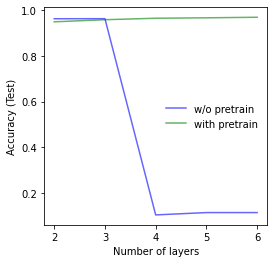

In [19]:
nlayers = [2, 3, 4, 5, 6]
plt.figure(figsize = (4,4))
plt.plot(nlayers, [i[0] for i in accuracies_test[:5]],label = f'w/o pretrain', c = 'blue', alpha = 0.6)
plt.plot(nlayers, [i[1] for i in accuracies_test[:5]], label = f'with pretrain', c = 'green', alpha = 0.6)

plt.ylabel('Accuracy (Test)')
plt.legend(frameon = False)
plt.xlabel('Number of layers')
plt.savefig('figures/accuracies_test_per_layers_200n', dpi = 600)

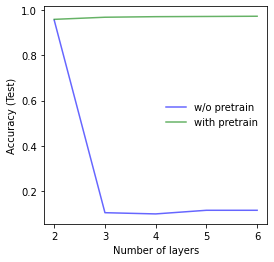

In [20]:
nlayers = [2, 3, 4, 5, 6]
plt.figure(figsize = (4,4))
plt.plot(nlayers, [i[0] for i in accuracies_test[5:]],label = f'w/o pretrain', c = 'blue', alpha = 0.6)
plt.plot(nlayers, [i[1] for i in accuracies_test[5:]], label = f'with pretrain', c = 'green', alpha = 0.6)

plt.ylabel('Accuracy (Test)')
plt.legend(frameon = False)
plt.xlabel('Number of layers')
plt.savefig('figures/accuracies_test_per_layers_500n', dpi = 600)

### Expérience 2

Dans cette expérience, on entraîne un DNN à 2 couches (0 couches cachées) et on fait varier le nombre de neurones. Cette expérience est répétée pour un DNN à 3 couches.

In [21]:
qs = [100, 200, 300, 500, 700]
nlayers = [0, 1]
epochs_retro = 200
epochs_pretrain = 100
lr = 0.1
batch_size = 512 

losses = []
accuracies_test = []
accuracies_train = []
for n in nlayers : 
    for q in qs : 
        print(f'DNN {n} layers with {q} neurons')
        sizes = [(X_train.size(1), q)]
        for j in range(n) : 
            sizes.append((q, q))
        sizes.append((q, 10))

        DNN_1 = init_DNN(len(sizes), sizes, device, random_state = 42)
        DNN_2 = init_DNN(len(sizes), sizes, device, random_state = 42)

        # RETRO SANS PRETRAIN #
        DNN_1, history_1 = retropropagation(X_train, y_train, DNN_1, epochs_retro, lr, batch_size)

        # RETRO AVEC PRETRAIN
        DNN_2 = pretrain_DNN(X_train, DNN_2, epochs_pretrain, lr, batch_size)
        DNN_2, history_2 = retropropagation(X_train, y_train, DNN_2, epochs_retro, lr, batch_size)
        
        accuracy_test_1 = test_DNN(X_test,y_test, DNN_1)
        accuracy_train_1 = test_DNN(X_train, y_train, DNN_1)

        accuracy_test_2 = test_DNN(X_test,y_test, DNN_2)
        accuracy_train_2 = test_DNN(X_train, y_train, DNN_2)

        losses.append((history_1, history_2))
        accuracies_train.append((accuracy_train_1, accuracy_train_2))
        accuracies_test.append((accuracy_test_1, accuracy_test_2))
        
        del DNN_1, DNN_2
        torch.cuda.empty_cache()
        gc.collect()

DNN 0 layers with 100 neurons


Epoch 200 | loss : 0.102 | accuracy  0.97: 100%|█| 200/200 [00:16<00:00, 12.46it
EPOCH 99 - Reconstruction Error: 16.1914: 100%|█| 100/100 [00:15<00:00,  6.29it/
Epoch 200 | loss : 0.194 | accuracy  0.94: 100%|█| 200/200 [00:16<00:00, 11.84it


DNN 0 layers with 200 neurons


Epoch 200 | loss : 0.105 | accuracy  0.97: 100%|█| 200/200 [00:21<00:00,  9.31it
EPOCH 99 - Reconstruction Error: 8.0537: 100%|█| 100/100 [00:22<00:00,  4.54it/s
Epoch 200 | loss : 0.135 | accuracy  0.96: 100%|█| 200/200 [00:23<00:00,  8.62it


DNN 0 layers with 300 neurons


Epoch 200 | loss : 0.113 | accuracy  0.97: 100%|█| 200/200 [00:29<00:00,  6.82it
EPOCH 99 - Reconstruction Error: 4.7587: 100%|█| 100/100 [00:31<00:00,  3.18it/s
Epoch 200 | loss : 0.112 | accuracy  0.97: 100%|█| 200/200 [00:30<00:00,  6.54it


DNN 0 layers with 500 neurons


Epoch 200 | loss : 0.127 | accuracy  0.96: 100%|█| 200/200 [00:39<00:00,  5.06it
EPOCH 99 - Reconstruction Error: 2.1406: 100%|█| 100/100 [00:39<00:00,  2.54it/s
Epoch 200 | loss : 0.086 | accuracy  0.98: 100%|█| 200/200 [00:40<00:00,  4.90it


DNN 0 layers with 700 neurons


Epoch 200 | loss : 0.135 | accuracy  0.96: 100%|█| 200/200 [00:50<00:00,  3.97it
EPOCH 99 - Reconstruction Error: 1.2867: 100%|█| 100/100 [00:54<00:00,  1.83it/s
Epoch 200 | loss : 0.072 | accuracy  0.98: 100%|█| 200/200 [00:51<00:00,  3.86it


DNN 1 layers with 100 neurons


Epoch 200 | loss : 0.102 | accuracy  0.97: 100%|█| 200/200 [00:29<00:00,  6.86it
EPOCH 99 - Reconstruction Error: 16.1858: 100%|█| 100/100 [00:20<00:00,  4.88it/
EPOCH 99 - Reconstruction Error: 1.2255: 100%|█| 100/100 [00:12<00:00,  7.72it/s
Epoch 200 | loss : 0.151 | accuracy  0.96: 100%|█| 200/200 [00:26<00:00,  7.43it


DNN 1 layers with 200 neurons


Epoch 200 | loss : 0.103 | accuracy  0.97: 100%|█| 200/200 [00:35<00:00,  5.56it
EPOCH 99 - Reconstruction Error: 8.0671: 100%|█| 100/100 [00:25<00:00,  3.97it/s
EPOCH 99 - Reconstruction Error: 2.3134: 100%|█| 100/100 [00:14<00:00,  6.84it/s
Epoch 200 | loss : 0.099 | accuracy  0.97: 100%|█| 200/200 [00:35<00:00,  5.62it


DNN 1 layers with 300 neurons


Epoch 200 | loss : 0.111 | accuracy  0.97: 100%|█| 200/200 [00:42<00:00,  4.66it
EPOCH 99 - Reconstruction Error: 4.7648: 100%|█| 100/100 [00:31<00:00,  3.13it/s
EPOCH 99 - Reconstruction Error: 2.9115: 100%|█| 100/100 [00:19<00:00,  5.25it/s
Epoch 200 | loss : 0.081 | accuracy  0.98: 100%|█| 200/200 [00:46<00:00,  4.33it


DNN 1 layers with 500 neurons


Epoch 200 | loss : 9.996 | accuracy  0.10: 100%|█| 200/200 [01:12<00:00,  2.75it
EPOCH 99 - Reconstruction Error: 2.1381: 100%|█| 100/100 [00:48<00:00,  2.05it/s
EPOCH 99 - Reconstruction Error: 3.0150: 100%|█| 100/100 [00:43<00:00,  2.29it/s
Epoch 200 | loss : 0.058 | accuracy  0.99: 100%|█| 200/200 [01:09<00:00,  2.88it


DNN 1 layers with 700 neurons


Epoch 200 | loss : 12.842 | accuracy  0.10: 100%|█| 200/200 [01:43<00:00,  1.93i
EPOCH 99 - Reconstruction Error: 1.2844: 100%|█| 100/100 [01:02<00:00,  1.61it/s
EPOCH 99 - Reconstruction Error: 3.6688: 100%|█| 100/100 [00:58<00:00,  1.72it/s
Epoch 200 | loss : 0.048 | accuracy  0.99: 100%|█| 200/200 [01:42<00:00,  1.95it


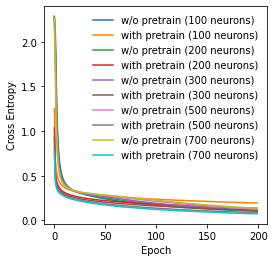

In [22]:
qs = [100, 200, 300, 500, 700]
plt.figure(figsize = (4,4))

for q,(i,j) in zip(qs,losses[:5]) : 
    plt.plot(i, label = f'w/o pretrain ({q} neurons)')
    plt.plot(j, label = f'with pretrain ({q} neurons)')
plt.ylabel('Cross Entropy')
plt.legend(frameon = False)
plt.xlabel('Epoch')
plt.savefig('figures/losses_per_neurons_0hl.png', dpi=600)

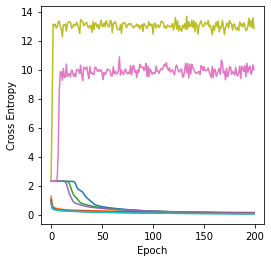

In [23]:
qs = [100, 200, 300, 500, 700]
plt.figure(figsize = (4,4))

for q,(i,j) in zip(qs,losses[5:]) : 
    plt.plot(i, label = f'w/o pretrain ({q} neurons)')
    plt.plot(j, label = f'with pretrain ({q} neurons)')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.savefig('figures/losses_per_neurons_2hl.png', dpi=600)

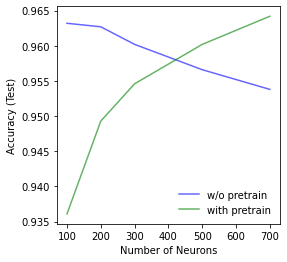

In [24]:
qs = [100, 200, 300, 500, 700]
plt.figure(figsize = (4,4))
plt.plot(qs, [i[0] for i in accuracies_test[:5]],label = f'w/o pretrain', c = 'blue', alpha = 0.6)
plt.plot(qs, [i[1] for i in accuracies_test[:5]], label = f'with pretrain', c = 'green', alpha = 0.6)

plt.ylabel('Accuracy (Test)')
plt.legend(frameon = False)
plt.xlabel('Number of Neurons')
plt.savefig('figures/accuracies_test_per_neurons_0hl', dpi = 600)

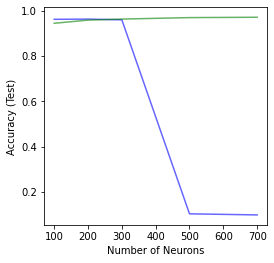

In [25]:
qs = [100, 200, 300, 500, 700]
plt.figure(figsize = (4,4))
plt.plot(qs, [i[0] for i in accuracies_test[5:]],label = f'w/o pretrain', c = 'blue', alpha = 0.6)
plt.plot(qs, [i[1] for i in accuracies_test[5:]], label = f'with pretrain', c = 'green', alpha = 0.6)

plt.ylabel('Accuracy (Test)')
#plt.legend(frameon = False)
plt.xlabel('Number of Neurons')
plt.savefig('figures/accuracies_test_per_neurons_2hl', dpi = 600)

### Expérience 3

Dans cette expérience, on fixe le nombre de couches à $2$ (ou $4$) avec $200$ neuronnes (ou $500$) et on fait varier le nombre de données d'entrainement.

In [26]:
qs = [200, 500]
nlayers = [0, 1]
n_data = [1000, 3000, 7000, 10000, 30000, 60000]
epochs_retro = 200
epochs_pretrain = 100
lr = 0.1
batch_size = 512 


all_losses = []
all_accuracies_test = []
all_accuracies_train = []

for n_images in n_data : 
    X_train, y_train, X_val, y_val, X_test, y_test = lire_mnist(device = device, val_size = 0, n_images = n_images)
    losses = []
    accuracies_test = []
    accuracies_train = []
    if n_images < 10000 : 
        batch_size = 64
    else : 
        batch_size = 512
    for n in nlayers : 
        for q in qs : 
            print(f'DNN {n} layers with {q} neurons trained on {n_images} images')
            sizes = [(X_train.size(1), q)]
            for j in range(n) : 
                sizes.append((q, q))
            sizes.append((q, 10))

            DNN_1 = init_DNN(len(sizes), sizes, device, random_state = 42)
            DNN_2 = init_DNN(len(sizes), sizes, device, random_state = 42)

            # RETRO SANS PRETRAIN #
            DNN_1, history_1 = retropropagation(X_train, y_train, DNN_1, epochs_retro, lr, batch_size)

            # RETRO AVEC PRETRAIN
            DNN_2 = pretrain_DNN(X_train, DNN_2, epochs_pretrain, lr, batch_size)
            DNN_2, history_2 = retropropagation(X_train, y_train, DNN_2, epochs_retro, lr, batch_size)

            accuracy_test_1 = test_DNN(X_test,y_test, DNN_1)
            accuracy_train_1 = test_DNN(X_train, y_train, DNN_1)

            accuracy_test_2 = test_DNN(X_test,y_test, DNN_2)
            accuracy_train_2 = test_DNN(X_train, y_train, DNN_2)

            losses.append((history_1, history_1))
            accuracies_train.append((accuracy_train_1, accuracy_train_2))
            accuracies_test.append((accuracy_test_1, accuracy_test_2))

            del DNN_1, DNN_2
            torch.cuda.empty_cache()
            gc.collect()
    all_losses.append(losses)
    all_accuracies_test.append(accuracies_test)
    all_accuracies_train.append(accuracies_train)

DNN 0 layers with 200 neurons trained on 1000 images


Epoch 200 | loss : 0.060 | accuracy  1.00: 100%|█| 200/200 [00:02<00:00, 77.63it
EPOCH 99 - Reconstruction Error: 9.3554: 100%|█| 100/100 [00:01<00:00, 66.10it/s
Epoch 200 | loss : 0.052 | accuracy  1.00: 100%|█| 200/200 [00:02<00:00, 78.47it


DNN 0 layers with 500 neurons trained on 1000 images


Epoch 200 | loss : 0.054 | accuracy  1.00: 100%|█| 200/200 [00:02<00:00, 74.92it
EPOCH 99 - Reconstruction Error: 3.7521: 100%|█| 100/100 [00:01<00:00, 62.44it/s
Epoch 200 | loss : 0.028 | accuracy  1.00: 100%|█| 200/200 [00:02<00:00, 74.24it


DNN 1 layers with 200 neurons trained on 1000 images


Epoch 200 | loss : 3.083 | accuracy  0.12: 100%|█| 200/200 [00:03<00:00, 57.77it
EPOCH 99 - Reconstruction Error: 9.3246: 100%|█| 100/100 [00:01<00:00, 62.04it/s
EPOCH 99 - Reconstruction Error: 2.4804: 100%|█| 100/100 [00:01<00:00, 64.77it/s
Epoch 200 | loss : 0.052 | accuracy  1.00: 100%|█| 200/200 [00:03<00:00, 59.61it


DNN 1 layers with 500 neurons trained on 1000 images


Epoch 200 | loss : 10.802 | accuracy  0.10: 100%|█| 200/200 [00:03<00:00, 52.92i
EPOCH 99 - Reconstruction Error: 3.7170: 100%|█| 100/100 [00:01<00:00, 61.91it/s
EPOCH 99 - Reconstruction Error: 1.7886: 100%|█| 100/100 [00:01<00:00, 68.58it/s
Epoch 200 | loss : 0.024 | accuracy  1.00: 100%|█| 200/200 [00:03<00:00, 57.98it


DNN 0 layers with 200 neurons trained on 3000 images


Epoch 200 | loss : 0.038 | accuracy  1.00: 100%|█| 200/200 [00:07<00:00, 28.52it
EPOCH 99 - Reconstruction Error: 7.0114: 100%|█| 100/100 [00:04<00:00, 22.93it/s
Epoch 200 | loss : 0.036 | accuracy  1.00: 100%|█| 200/200 [00:06<00:00, 29.75it


DNN 0 layers with 500 neurons trained on 3000 images


Epoch 200 | loss : 0.040 | accuracy  1.00: 100%|█| 200/200 [00:08<00:00, 24.86it
EPOCH 99 - Reconstruction Error: 1.4131: 100%|█| 100/100 [00:05<00:00, 18.94it/s
Epoch 200 | loss : 0.017 | accuracy  1.00: 100%|█| 200/200 [00:07<00:00, 26.81it


DNN 1 layers with 200 neurons trained on 3000 images


Epoch 200 | loss : 3.321 | accuracy  0.09: 100%|█| 200/200 [00:10<00:00, 19.61it
EPOCH 99 - Reconstruction Error: 6.9974: 100%|█| 100/100 [00:04<00:00, 22.34it/s
EPOCH 99 - Reconstruction Error: 2.2542: 100%|█| 100/100 [00:04<00:00, 21.60it/s
Epoch 200 | loss : 0.025 | accuracy  1.00: 100%|█| 200/200 [00:10<00:00, 18.70it


DNN 1 layers with 500 neurons trained on 3000 images


Epoch 200 | loss : 11.069 | accuracy  0.09: 100%|█| 200/200 [00:10<00:00, 18.30i
EPOCH 99 - Reconstruction Error: 1.3984: 100%|█| 100/100 [00:04<00:00, 20.42it/s
EPOCH 99 - Reconstruction Error: 2.3311: 100%|█| 100/100 [00:05<00:00, 19.85it/s
Epoch 200 | loss : 0.012 | accuracy  1.00: 100%|█| 200/200 [00:10<00:00, 18.49it


DNN 0 layers with 200 neurons trained on 7000 images


Epoch 200 | loss : 0.025 | accuracy  1.00: 100%|█| 200/200 [00:15<00:00, 12.56it
EPOCH 99 - Reconstruction Error: 6.1379: 100%|█| 100/100 [00:09<00:00, 10.03it/s
Epoch 200 | loss : 0.028 | accuracy  1.00: 100%|█| 200/200 [00:14<00:00, 13.68it


DNN 0 layers with 500 neurons trained on 7000 images


Epoch 200 | loss : 0.030 | accuracy  1.00: 100%|█| 200/200 [00:14<00:00, 13.59it
EPOCH 99 - Reconstruction Error: 0.6313: 100%|█| 100/100 [00:10<00:00,  9.17it/s
Epoch 200 | loss : 0.011 | accuracy  1.00: 100%|█| 200/200 [00:15<00:00, 12.77it


DNN 1 layers with 200 neurons trained on 7000 images


Epoch 200 | loss : 1.127 | accuracy  0.73: 100%|█| 200/200 [00:21<00:00,  9.49it
EPOCH 99 - Reconstruction Error: 6.1646: 100%|█| 100/100 [00:09<00:00, 10.13it/s
EPOCH 99 - Reconstruction Error: 2.1388: 100%|█| 100/100 [00:09<00:00, 10.78it/s
Epoch 200 | loss : 0.015 | accuracy  1.00: 100%|█| 200/200 [00:20<00:00,  9.84it


DNN 1 layers with 500 neurons trained on 7000 images


Epoch 200 | loss : 11.236 | accuracy  0.11: 100%|█| 200/200 [00:22<00:00,  8.97i
EPOCH 99 - Reconstruction Error: 0.6359: 100%|█| 100/100 [00:11<00:00,  8.89it/s
EPOCH 99 - Reconstruction Error: 2.9344: 100%|█| 100/100 [00:10<00:00,  9.38it/s
Epoch 200 | loss : 0.007 | accuracy  1.00: 100%|█| 200/200 [00:21<00:00,  9.40it


DNN 0 layers with 200 neurons trained on 10000 images


Epoch 200 | loss : 0.236 | accuracy  0.94: 100%|█| 200/200 [00:04<00:00, 45.25it
EPOCH 99 - Reconstruction Error: 14.2054: 100%|█| 100/100 [00:04<00:00, 24.00it/
Epoch 200 | loss : 0.178 | accuracy  0.95: 100%|█| 200/200 [00:04<00:00, 44.72it


DNN 0 layers with 500 neurons trained on 10000 images


Epoch 200 | loss : 0.244 | accuracy  0.93: 100%|█| 200/200 [00:06<00:00, 29.21it
EPOCH 99 - Reconstruction Error: 8.1165: 100%|█| 100/100 [00:06<00:00, 15.14it/s
Epoch 200 | loss : 0.152 | accuracy  0.96: 100%|█| 200/200 [00:06<00:00, 29.11it


DNN 1 layers with 200 neurons trained on 10000 images


Epoch 200 | loss : 0.678 | accuracy  0.79: 100%|█| 200/200 [00:06<00:00, 33.19it
EPOCH 99 - Reconstruction Error: 14.2096: 100%|█| 100/100 [00:04<00:00, 24.06it/
EPOCH 99 - Reconstruction Error: 2.6511: 100%|█| 100/100 [00:02<00:00, 43.93it/s
Epoch 200 | loss : 0.169 | accuracy  0.95: 100%|█| 200/200 [00:05<00:00, 33.73it


DNN 1 layers with 500 neurons trained on 10000 images


Epoch 200 | loss : 9.869 | accuracy  0.11: 100%|█| 200/200 [00:10<00:00, 18.31it
EPOCH 99 - Reconstruction Error: 8.1313: 100%|█| 100/100 [00:06<00:00, 14.63it/s
EPOCH 99 - Reconstruction Error: 2.3497: 100%|█| 100/100 [00:05<00:00, 17.01it/s
Epoch 200 | loss : 0.133 | accuracy  0.97: 100%|█| 200/200 [00:12<00:00, 16.17it


DNN 0 layers with 200 neurons trained on 30000 images


Epoch 200 | loss : 0.162 | accuracy  0.95: 100%|█| 200/200 [00:15<00:00, 12.92it
EPOCH 99 - Reconstruction Error: 9.7860: 100%|█| 100/100 [00:14<00:00,  6.92it/s
Epoch 200 | loss : 0.155 | accuracy  0.96: 100%|█| 200/200 [00:15<00:00, 13.23it


DNN 0 layers with 500 neurons trained on 30000 images


Epoch 200 | loss : 0.195 | accuracy  0.95: 100%|█| 200/200 [00:21<00:00,  9.49it
EPOCH 99 - Reconstruction Error: 3.7370: 100%|█| 100/100 [00:19<00:00,  5.02it/s
Epoch 200 | loss : 0.107 | accuracy  0.97: 100%|█| 200/200 [00:20<00:00,  9.81it


DNN 1 layers with 200 neurons trained on 30000 images


Epoch 200 | loss : 0.220 | accuracy  0.94: 100%|█| 200/200 [00:19<00:00, 10.20it
EPOCH 99 - Reconstruction Error: 9.7628: 100%|█| 100/100 [00:14<00:00,  6.93it/s
EPOCH 99 - Reconstruction Error: 2.5460: 100%|█| 100/100 [00:08<00:00, 12.00it/s
Epoch 200 | loss : 0.128 | accuracy  0.96: 100%|█| 200/200 [00:21<00:00,  9.26it


DNN 1 layers with 500 neurons trained on 30000 images


Epoch 200 | loss : 9.361 | accuracy  0.10: 100%|█| 200/200 [00:30<00:00,  6.51it
EPOCH 99 - Reconstruction Error: 3.7416: 100%|█| 100/100 [00:21<00:00,  4.74it/s
EPOCH 99 - Reconstruction Error: 2.9103: 100%|█| 100/100 [00:17<00:00,  5.64it/s
Epoch 200 | loss : 0.083 | accuracy  0.98: 100%|█| 200/200 [00:32<00:00,  6.23it


DNN 0 layers with 200 neurons trained on 60000 images


Epoch 200 | loss : 0.105 | accuracy  0.97: 100%|█| 200/200 [00:30<00:00,  6.55it
EPOCH 99 - Reconstruction Error: 8.0537: 100%|█| 100/100 [00:24<00:00,  4.02it/s
Epoch 200 | loss : 0.135 | accuracy  0.96: 100%|█| 200/200 [00:27<00:00,  7.28it


DNN 0 layers with 500 neurons trained on 60000 images


Epoch 200 | loss : 0.127 | accuracy  0.96: 100%|█| 200/200 [00:41<00:00,  4.84it
EPOCH 99 - Reconstruction Error: 2.1406: 100%|█| 100/100 [00:41<00:00,  2.40it/s
Epoch 200 | loss : 0.086 | accuracy  0.98: 100%|█| 200/200 [00:41<00:00,  4.84it


DNN 1 layers with 200 neurons trained on 60000 images


Epoch 200 | loss : 0.103 | accuracy  0.97: 100%|█| 200/200 [00:36<00:00,  5.44it
EPOCH 99 - Reconstruction Error: 8.0671: 100%|█| 100/100 [00:25<00:00,  3.93it/s
EPOCH 99 - Reconstruction Error: 2.3134: 100%|█| 100/100 [00:14<00:00,  6.86it/s
Epoch 200 | loss : 0.099 | accuracy  0.97: 100%|█| 200/200 [00:36<00:00,  5.46it


DNN 1 layers with 500 neurons trained on 60000 images


Epoch 200 | loss : 9.996 | accuracy  0.10: 100%|█| 200/200 [01:06<00:00,  3.00it
EPOCH 99 - Reconstruction Error: 2.1381: 100%|█| 100/100 [00:43<00:00,  2.31it/s
EPOCH 99 - Reconstruction Error: 3.0150: 100%|█| 100/100 [00:36<00:00,  2.73it/s
Epoch 200 | loss : 0.058 | accuracy  0.99: 100%|█| 200/200 [01:10<00:00,  2.83it


In [30]:
all_acc_0hl_200 = []
all_acc_0hl_500 = []
all_acc_0hl_200_pre = []
all_acc_0hl_500_pre = []

all_acc_1hl_200 = []
all_acc_1hl_500 = []
all_acc_1hl_200_pre = []
all_acc_1hl_500_pre = []

for acc in all_accuracies_test : 
    all_acc_0hl_200.append(acc[0][0]) 
    all_acc_0hl_200_pre.append(acc[0][1])
    
    all_acc_0hl_500.append(acc[1][0]) 
    all_acc_0hl_500_pre.append(acc[1][1])
    
    all_acc_1hl_200.append(acc[2][0]) 
    all_acc_1hl_200_pre.append(acc[2][1])
    
    all_acc_1hl_500.append(acc[3][0]) 
    all_acc_1hl_500_pre.append(acc[3][1])

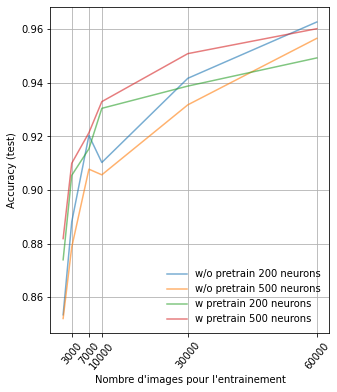

In [31]:
plt.figure(figsize = (5,6))
plt.plot(n_data, all_acc_0hl_200, label = 'w/o pretrain 200 neurons', alpha = 0.6)
plt.plot(n_data, all_acc_0hl_500, label = 'w/o pretrain 500 neurons', alpha = 0.6)
plt.plot(n_data, all_acc_0hl_200_pre, label = 'w pretrain 200 neurons', alpha = 0.6)
plt.plot(n_data, all_acc_0hl_500_pre, label = 'w pretrain 500 neurons', alpha = 0.6)
plt.legend(frameon = False)
_ = plt.xticks([3000, 7000] + n_data[-3:], rotation = 50)
plt.grid()
plt.xlabel("Nombre d'images pour l'entrainement")
plt.ylabel('Accuracy (test)')
plt.savefig('figures/accuracies_test_per_nimages_0hl', dpi = 600)

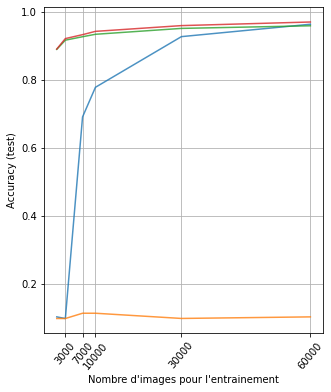

In [32]:
plt.figure(figsize = (5,6))
plt.plot(n_data, all_acc_1hl_200, label = 'w/o pretrain 200 neurons', alpha = 0.8)
plt.plot(n_data, all_acc_1hl_500, label = 'w/o pretrain 500 neurons', alpha = 0.8)
plt.plot(n_data, all_acc_1hl_200_pre, label = 'w pretrain 200 neurons', alpha = 0.8)
plt.plot(n_data, all_acc_1hl_500_pre, label = 'w pretrain 500 neurons', alpha = 0.8)
#plt.legend(frameon = False)
_ = plt.xticks([3000, 7000] + n_data[-3:], rotation = 50)
plt.grid()
plt.xlabel("Nombre d'images pour l'entrainement")
plt.ylabel('Accuracy (test)')
plt.savefig('figures/accuracies_test_per_nimages_2hl', dpi = 600)

### Hyperparameter tuning

Dans cette section, nous souhaitons chercher le meilleur modèle en terme de nombre de neuronnes et de couches cachés (avec pré entraînement ou pas) dans le sens du modèle qui donne le meilleur taux de bonne classification sur le jeu de test. Afin de ne pas avoir à trouver un nombre parfait d'epochs pour la rétropropagation, nous utiliserons un jeu de validation qui contient $5\%$ du jeu d'entraînement et l'utiliserons comme critére d'arrêt pour l'optimisation. Cette pratique très utilisée, l'early stopping, permet à nos modèles de ne pas trop overfit sur les données d'entraînement.

Grâce aux expériences précédentes, nous savons qu'un DNN $2$ couches cachées ou plus ne converge pas sans pré entrainement, et que le pré entrainement n'est pas forcément utile sur un DNN avec peu de couches cachées. Nous avons vu également que plus le nombre de neurones est grand et plus un DNN avec pré entrainement est bon. 

Nous allons donc procéder à l'optimisation des modèles suivant:

- DNN 2 couches + pas de prétrain: 100 neurones
- DNN 3 couches + pas de prétrain: 100 ou 200 neurones
- DNN 4 couches + prétrain: 200 ou 500 ou 1000 neurones
- DNN 5 couches + prétrain: 200 ou 500 ou 1000 neurones
- DNN 6 couches + prétrain: 200 ou 500 ou 1000 neurones


In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = lire_mnist(device = device, val_size = 0.05)

In [4]:
archs = [
    [(X_train.size(1), 100), (100,10)],
    [(X_train.size(1), 100), (100,100), (100,10)], 
    [(X_train.size(1), 200), (200,200), (200,10)], 
    [(X_train.size(1), 500), (500,500), (500,500),(500,10)], 
    [(X_train.size(1), 1000), (1000,1000), (1000,1000),(1000,10)], 
    [(X_train.size(1), 500), (500,500), (500,500),(500,500),(500,10)], 
    [(X_train.size(1), 1000), (1000,1000), (1000,1000),(1000,1000),(1000,10)], 
    [(X_train.size(1), 500), (500,500), (500,500),(500,500),(500,500),(500,10)], 
    [(X_train.size(1), 1000), (1000,1000), (1000,1000),(1000,1000),(1000,1000),(1000,10)], 
    
    [(X_train.size(1), 500), (500,500), (500,500),(500,10)], 
    [(X_train.size(1), 1000), (1000,1000), (1000,1000),(1000,10)], 
    [(X_train.size(1), 500), (500,500), (500,500),(500,500),(500,10)], 
    [(X_train.size(1), 1000), (1000,1000), (1000,1000),(1000,1000),(1000,10)], 
    [(X_train.size(1), 500), (500,500), (500,500),(500,500),(500,500),(500,10)], 
    [(X_train.size(1), 1000), (1000,1000), (1000,1000),(1000,1000),(1000,1000),(1000,10)],
]

In [6]:
accuracies_test = []
lr = 0.1
batch_size = 512
epochs_pretrain = 100
epochs_retro = 2000
times = []
converging_times = []

for idx, arch in enumerate(archs): 
    n = len(arch)
    q = arch[0][1]
    print(f'DNN {n} layers with {q} neurons')
    DNN = init_DNN(n, arch, device, random_state = 42)
    
    t0 = time()
    if idx >= 3  :
        if idx >= 9 : 
            epochs_pretrain = 200
        DNN = pretrain_DNN(X_train, DNN, epochs_pretrain, lr, batch_size)
    DNN, history = retropropagation(X_train, y_train, DNN, epochs_retro, lr, batch_size, X_val, y_val,
                                   esr = 30)
    times.append(time()-t0)
    converging_times.append(len(history) - 30)
    accuracy_test = test_DNN(X_test, y_test, DNN)


    accuracies_test.append(accuracy_test)
    print(f'Test accuracy: {accuracy_test:0.3f}')
    del DNN
    torch.cuda.empty_cache()
    gc.collect()

DNN 2 layers with 100 neurons


Epoch 238 | loss : 0.090 | accuracy  0.96:  12%| | 238/2000 [00:21<02:37, 11.18i


Test accuracy: 0.963
DNN 3 layers with 100 neurons


Epoch 331 | loss : 0.050 | accuracy  0.97:  17%|▏| 331/2000 [00:41<03:30,  7.95i


Test accuracy: 0.967
DNN 3 layers with 200 neurons


Epoch 355 | loss : 0.044 | accuracy  0.97:  18%|▏| 355/2000 [00:50<03:54,  7.02i


Test accuracy: 0.969
DNN 4 layers with 500 neurons


EPOCH 99 - Reconstruction Error: 2.2343: 100%|█| 100/100 [00:37<00:00,  2.66it/s
EPOCH 99 - Reconstruction Error: 2.7916: 100%|█| 100/100 [00:32<00:00,  3.07it/s
EPOCH 99 - Reconstruction Error: 2.9884: 100%|█| 100/100 [00:32<00:00,  3.06it/s
Epoch 244 | loss : 0.035 | accuracy  0.97:  12%| | 244/2000 [01:30<10:53,  2.69i


Test accuracy: 0.972
DNN 4 layers with 1000 neurons


EPOCH 99 - Reconstruction Error: 0.8933: 100%|█| 100/100 [01:22<00:00,  1.22it/s
EPOCH 99 - Reconstruction Error: 9.9365: 100%|█| 100/100 [01:42<00:00,  1.02s/it
EPOCH 99 - Reconstruction Error: 1.6819: 100%|█| 100/100 [01:39<00:00,  1.00it/s
Epoch 197 | loss : 0.045 | accuracy  0.97:  10%| | 197/2000 [03:09<28:56,  1.04i


Test accuracy: 0.969
DNN 5 layers with 500 neurons


EPOCH 99 - Reconstruction Error: 2.2385: 100%|█| 100/100 [00:40<00:00,  2.50it/s
EPOCH 99 - Reconstruction Error: 2.9364: 100%|█| 100/100 [00:32<00:00,  3.08it/s
EPOCH 99 - Reconstruction Error: 3.0586: 100%|█| 100/100 [00:33<00:00,  3.01it/s
EPOCH 99 - Reconstruction Error: 1.7465: 100%|█| 100/100 [00:32<00:00,  3.05it/s
Epoch 217 | loss : 0.034 | accuracy  0.97:  11%| | 217/2000 [01:36<13:10,  2.26i


Test accuracy: 0.972
DNN 5 layers with 1000 neurons


EPOCH 99 - Reconstruction Error: 0.8944: 100%|█| 100/100 [01:19<00:00,  1.25it/s
EPOCH 99 - Reconstruction Error: 12.4484: 100%|█| 100/100 [01:40<00:00,  1.00s/i
EPOCH 99 - Reconstruction Error: 1.2865: 100%|█| 100/100 [01:39<00:00,  1.00it/s
EPOCH 99 - Reconstruction Error: 2.1128: 100%|█| 100/100 [01:42<00:00,  1.02s/it
Epoch 236 | loss : 0.030 | accuracy  0.97:  12%| | 236/2000 [05:24<40:28,  1.38s


Test accuracy: 0.973
DNN 6 layers with 500 neurons


EPOCH 99 - Reconstruction Error: 2.2343: 100%|█| 100/100 [00:45<00:00,  2.20it/s
EPOCH 99 - Reconstruction Error: 3.1051: 100%|█| 100/100 [00:36<00:00,  2.72it/s
EPOCH 99 - Reconstruction Error: 3.1008: 100%|█| 100/100 [00:35<00:00,  2.83it/s
EPOCH 99 - Reconstruction Error: 1.7537: 100%|█| 100/100 [00:35<00:00,  2.82it/s
EPOCH 99 - Reconstruction Error: 1.9515: 100%|█| 100/100 [00:39<00:00,  2.53it/s
Epoch 162 | loss : 0.042 | accuracy  0.97:   8%| | 162/2000 [01:30<17:08,  1.79i


Test accuracy: 0.971
DNN 6 layers with 1000 neurons


EPOCH 99 - Reconstruction Error: 0.8936: 100%|█| 100/100 [01:24<00:00,  1.18it/s
EPOCH 99 - Reconstruction Error: 14.3425: 100%|█| 100/100 [01:50<00:00,  1.10s/i
EPOCH 99 - Reconstruction Error: 1.1717: 100%|█| 100/100 [01:45<00:00,  1.06s/it
EPOCH 99 - Reconstruction Error: 2.1549: 100%|█| 100/100 [01:45<00:00,  1.05s/it
EPOCH 99 - Reconstruction Error: 1.0115: 100%|█| 100/100 [01:44<00:00,  1.05s/it
Epoch 214 | loss : 0.029 | accuracy  0.97:  11%| | 214/2000 [06:29<54:11,  1.82s


Test accuracy: 0.973
DNN 4 layers with 500 neurons


EPOCH 199 - Reconstruction Error: 0.9796: 100%|█| 200/200 [01:33<00:00,  2.13it/
EPOCH 199 - Reconstruction Error: 2.4639: 100%|█| 200/200 [01:21<00:00,  2.47it/
EPOCH 199 - Reconstruction Error: 3.7910: 100%|█| 200/200 [01:25<00:00,  2.34it/
Epoch 210 | loss : 0.045 | accuracy  0.97:  10%| | 210/2000 [01:19<11:20,  2.63i


Test accuracy: 0.968
DNN 4 layers with 1000 neurons


EPOCH 199 - Reconstruction Error: 0.2611: 100%|█| 200/200 [02:54<00:00,  1.15it/
EPOCH 199 - Reconstruction Error: 32.6754: 100%|█| 200/200 [03:34<00:00,  1.07s/
EPOCH 199 - Reconstruction Error: 4.9871: 100%|█| 200/200 [03:34<00:00,  1.07s/i
Epoch 329 | loss : 0.036 | accuracy  0.97:  16%|▏| 329/2000 [05:56<30:09,  1.08s


Test accuracy: 0.970
DNN 5 layers with 500 neurons


EPOCH 199 - Reconstruction Error: 0.9775: 100%|█| 200/200 [01:24<00:00,  2.37it/
EPOCH 199 - Reconstruction Error: 2.2826: 100%|█| 200/200 [01:17<00:00,  2.57it/
EPOCH 199 - Reconstruction Error: 3.7251: 100%|█| 200/200 [01:17<00:00,  2.58it/
EPOCH 199 - Reconstruction Error: 1.7106: 100%|█| 200/200 [01:13<00:00,  2.71it/
Epoch 200 | loss : 0.035 | accuracy  0.97:  10%| | 200/2000 [01:43<15:30,  1.94i


Test accuracy: 0.969
DNN 5 layers with 1000 neurons


EPOCH 199 - Reconstruction Error: 0.2617: 100%|█| 200/200 [02:53<00:00,  1.15it/
EPOCH 199 - Reconstruction Error: 83.9064: 100%|█| 200/200 [03:27<00:00,  1.04s/
EPOCH 199 - Reconstruction Error: 0.2066: 100%|█| 200/200 [03:19<00:00,  1.00it/
EPOCH 199 - Reconstruction Error: 8.5433: 100%|█| 200/200 [03:14<00:00,  1.03it/
Epoch 214 | loss : 0.237 | accuracy  0.91:  11%| | 214/2000 [04:42<39:15,  1.32s


Test accuracy: 0.904
DNN 6 layers with 500 neurons


EPOCH 199 - Reconstruction Error: 0.9753: 100%|█| 200/200 [01:24<00:00,  2.36it/
EPOCH 199 - Reconstruction Error: 2.3145: 100%|█| 200/200 [01:06<00:00,  2.99it/
EPOCH 199 - Reconstruction Error: 3.6816: 100%|█| 200/200 [01:05<00:00,  3.04it/
EPOCH 199 - Reconstruction Error: 1.7472: 100%|█| 200/200 [01:05<00:00,  3.05it/
EPOCH 199 - Reconstruction Error: 2.2950: 100%|█| 200/200 [01:10<00:00,  2.82it/
Epoch 136 | loss : 0.052 | accuracy  0.97:   7%| | 136/2000 [01:17<17:47,  1.75i


Test accuracy: 0.969
DNN 6 layers with 1000 neurons


EPOCH 199 - Reconstruction Error: 0.2614: 100%|█| 200/200 [02:43<00:00,  1.22it/
EPOCH 199 - Reconstruction Error: 37.1861: 100%|█| 200/200 [03:29<00:00,  1.05s/
EPOCH 199 - Reconstruction Error: 3.7734: 100%|█| 200/200 [03:32<00:00,  1.06s/i
EPOCH 199 - Reconstruction Error: 10.5794: 100%|█| 200/200 [03:30<00:00,  1.05s/
EPOCH 199 - Reconstruction Error: 0.3605: 100%|█| 200/200 [03:26<00:00,  1.03s/i
Epoch 287 | loss : 0.039 | accuracy  0.96:  14%|▏| 287/2000 [08:30<50:46,  1.78s

Test accuracy: 0.963


In [11]:
df_dic = {
    'Nb de couches cachées' : [0, 1, 1, 2, 2, 3, 3, 4, 4 , 2, 2 ,3 ,3 ,4 ,4],
    'Nb de neurones' : [100, 100, 200, 500, 1000, 500, 1000, 500, 1000, 500, 1000, 500, 1000, 500, 1000],
    'Pré entraînement' : ['non','non','non','oui','oui','oui','oui','oui','oui','oui','oui','oui','oui','oui','oui'],
    'Epochs (pré entraînement)' : ['-','-','-', 100, 100, 100, 100, 100, 100, 200, 200, 200, 200, 200, 200],
    "Epochs" : converging_times,
    "Temps d'entraînement (s)" : times, 
    'Accuracy' : accuracies_test,
}
df = pd.DataFrame(df_dic)

In [14]:
print(df.to_latex())

\begin{tabular}{lrrllrrr}
\toprule
{} &  Nb de couches cachées &  Nb de neurones & Pré entraînement & Epochs (pré entraînement) &  Epochs &  Temps d'entraînement (s) &  Accuracy \\
\midrule
0  &                      0 &             100 &              non &                         - &     208 &                 21.296586 &    0.9632 \\
1  &                      1 &             100 &              non &                         - &     301 &                 41.653213 &    0.9675 \\
2  &                      1 &             200 &              non &                         - &     325 &                 50.542730 &    0.9691 \\
3  &                      2 &             500 &              oui &                       100 &     214 &                193.580096 &    0.9722 \\
4  &                      2 &            1000 &              oui &                       100 &     167 &                473.721500 &    0.9693 \\
5  &                      3 &             500 &              oui &              